什么是填充?
首先, 卷积核越大, 可以更快地减小输出大小
越大的卷积核, 最大层数就越低(输出的矩阵大小＜卷积核时最大)
卷积核越大, 其对学习层数的限制就越大, 那如果我们希望更多的层数怎么办? 填充就可以解决这个问题

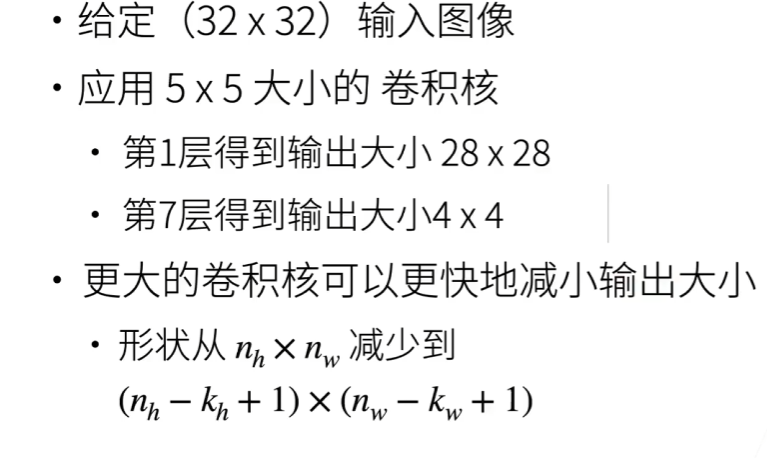

填充: 在输入的四周加入额外的行和列
下图通过填充, 得到了4×4更大的矩阵   

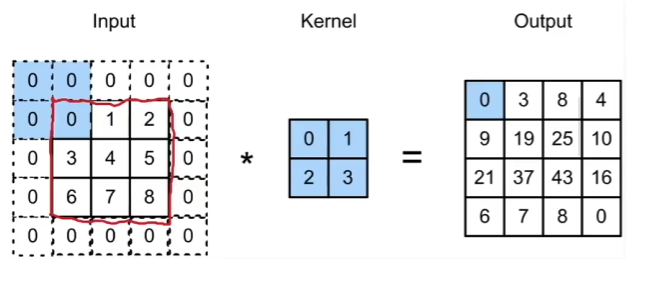

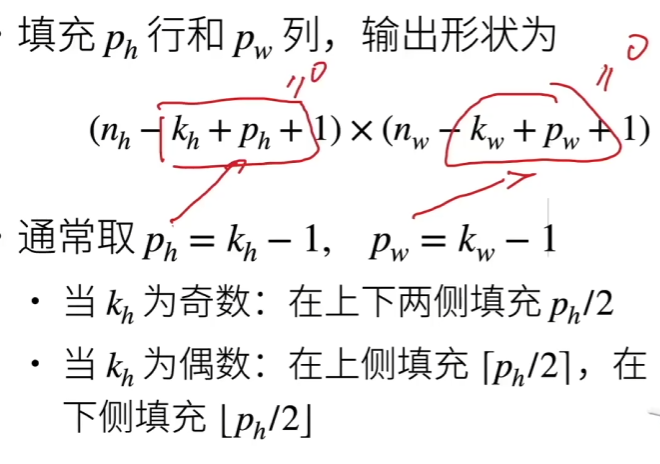

什么是步幅?
给定一个较大的矩阵和较小的核矩阵, 想要得到较小的输出, 需要较多的层数
步幅可以解决这类问题: 
步幅: 自主选择每一步的幅度(如果最后跳不了了, 就不跳了)
下图利用步幅, 得到了一个2×2的矩阵

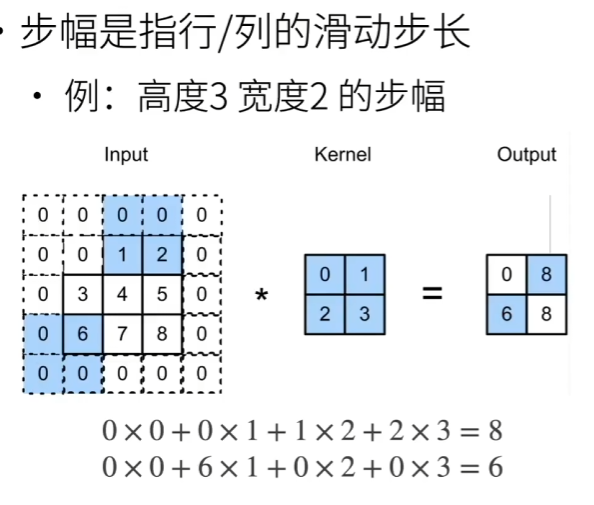

填充和步幅是卷积层的超参数
填充在输入周围添加额外的行/列，来控制输出形状的减
少量
步幅是每次滑动核窗口时的行/列的步长，可以成倍的减少
输出形状

In [ ]:
# 在所有侧边填充1个像素
import torch
from torch import nn

def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

In [ ]:
# 填充不同的高度和宽度
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

In [ ]:
# 将高度和宽度的步幅设置为2
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

In [ ]:
# 一个稍微复杂的例子
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

RGB图需要三个通道来完整表示, 不然就会变成通道为1的灰度图, 对于多个输入通道, 每个通道都有一个卷积核, 结果是所有通道卷积结果的和:
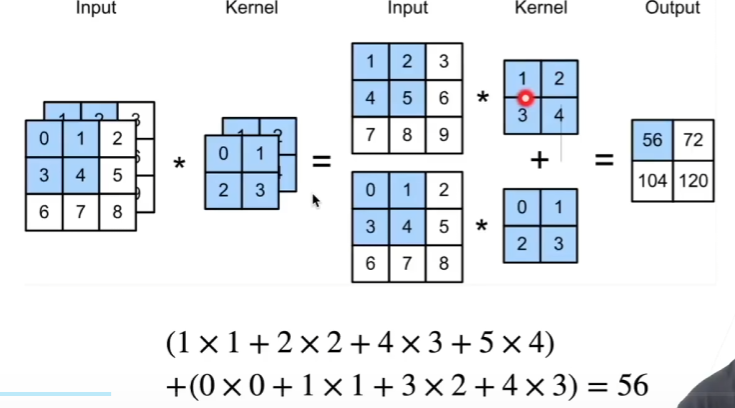

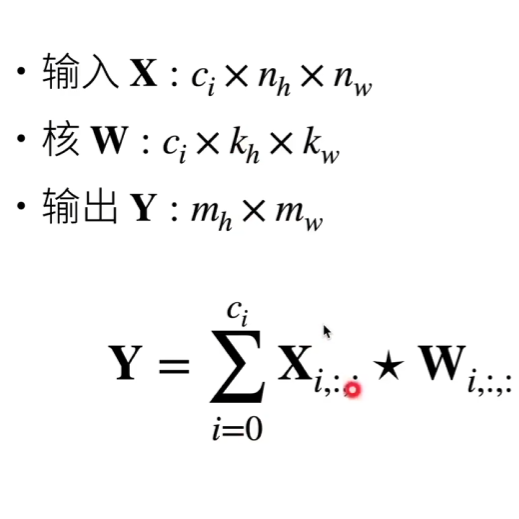

不管有多少个输入通道, 我们只会得到一个输出通道.
如何得到多输出通道
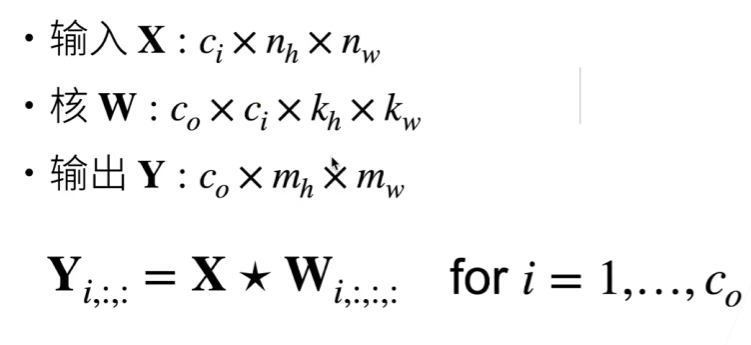
Co表示多个输出通道

多输出通道使得每个输出通道可以识别特定的模式
输入通道核识别并组合输入中模式(可以把特定的输入加权, 达到组合识别)

kw = kh = 1卷积层: 不识别空间模式只是融合通道

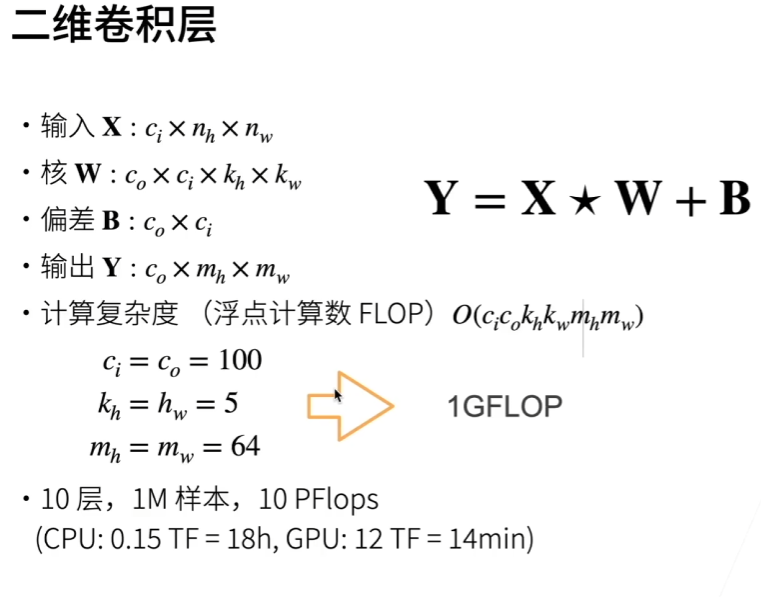

输出的通道数是当前卷积层的超参数
每一个输入通道都有独立的二维卷积核, 所有通道的结果相加得到一个输出的通道
每个输出的通道都有一个独立的三维卷积核

In [ ]:
# 代码实现
import torch
from d2l import torch as d2l

# 多输入通道的二维互相关（卷积）操作
def corr2d_multi_in(X, K):
    # X 是多通道输入（例如RGB图像的3个通道），形状通常为 (输入通道数, 高度, 宽度)
    # K 是对应每个输入通道的卷积核，形状通常为 (输入通道数, 卷积核高度, 卷积核宽度)\

    # 对每一对（输入通道x和卷积核k），调用单通道卷积函数 d2l.corr2d(x, k) 进行计算
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

# 验证: 多输入, 单输出
corr2d_multi_in(X, K)

In [ ]:
def corr2d_multi_in_out(X, K):
    # ​遍历每个输出通道的卷积核组：
    # K 的形状是 (C_out, C_in, K_h, K_w)，每次循环取出一个 k，形状为 (C_in, K_h, K_w)，表示一个输出通道对应的卷积核组。
    # torch.stack(..., dim=0)：将 C_out 个单通道输出（形状均为 (H_out, W_out)）沿维度 0 堆叠。
    # 最终输出形状为 (C_out, H_out, W_out)，即多通道特征图
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

K = torch.stack((K, K + 1, K + 2), 0)
K.shape

In [ ]:
corr2d_multi_in_out(X, K)

In [ ]:
# 矩阵乘法实现 1x1 卷积（corr2d_multi_in_out_1x1）与传统滑动窗口卷积（corr2d_multi_in_out）的结果是否相同
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6
# 1x1 卷积本质是对每个空间位置的输入通道进行线性组合（权重由 K 提供），与全连接层等价

池化层
问题来源: 积对位置十分敏感, 一个位置的偏移就可能导致0输出
以下图为例, 简单的垂直边缘检测中, 如果一个边缘的像素偏移了, 就检测不出边缘
所以: 需要一定程度的平移不变性

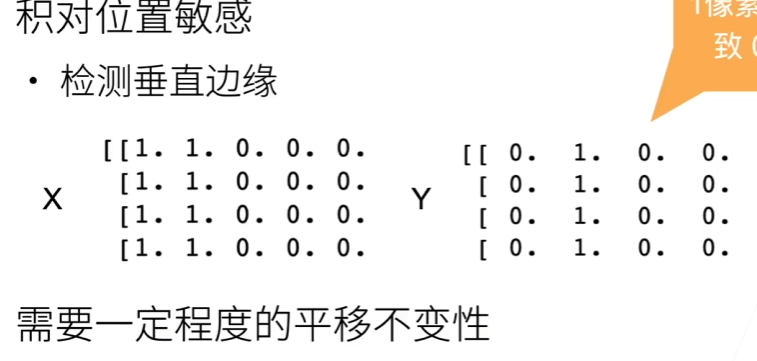

最大池化层: 滑动窗口, 返回滑动窗口区域中的最大值
最大值被扩散了, 池化后的数据对像素偏移的容忍性更高
池化层也具有:填充、步幅、窗口大小这些超参数

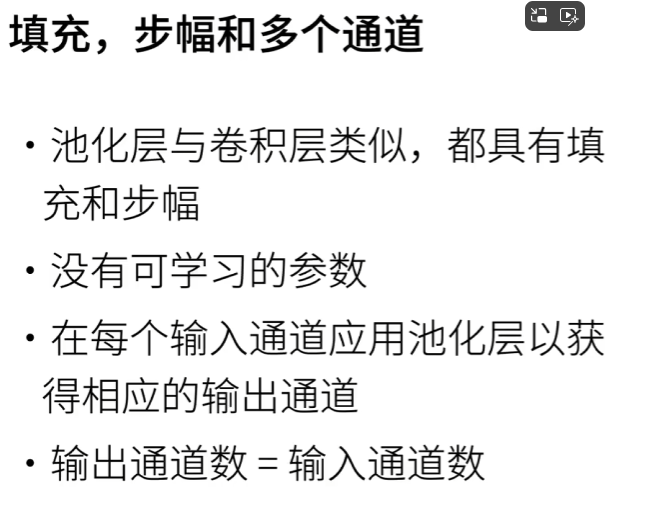

最大池化层: 每个窗口中最强的模式信号
平均池化层: 最大操作转化为取平均操作

In [ ]:
# 代码实现：池化层的正向传播
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size    # 池化窗口的高度和宽度
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))   # 初始化输出矩阵
    for i in range(Y.shape[0]): # 遍历输出高度方向
        for j in range(Y.shape[1]): # 遍历输出宽度方向
            window = X[i:i + p_h, j:j + p_w]  # 提取当前池化窗口区域
            if mode == 'max':
                Y[i, j] = window.max()  # 最大池化
            elif mode == 'avg':
                Y[i, j] = window.mean()  # 平均池化
    return Y
# 仅支持单通道输入​无步幅和填充控制的简单池化层

In [ ]:
# 验证
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))
pool2d(X, (2, 2), 'avg')

In [ ]:
# 通过使用 PyTorch 的 nn.MaxPool2d 模块
pool2d = nn.MaxPool2d(3, padding=1, stride=2) # 窗口大小3*3, 设置填充和步幅
pool2d(X)

pool2d = nn.MaxPool2d((2, 3), padding=(1, 1), stride=(2, 3))# 窗口大小2*3, 设置填充和步幅
pool2d(X)

In [ ]:
# 双通道:
X = torch.cat((X, X + 1), 1)
X

pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)